# 토픽 모델링과 네트워크 분석의 결합

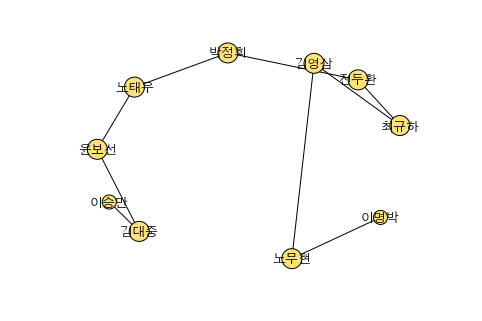

In [5]:
# 토픽에 의한 문서 군집화

import sys
from collections import defaultdict
from itertools import combinations
import ujson
from gensim import corpora
from gensim import models
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import networkx as nx
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

FEATURE_POSES = ["NC", "NQ"]
MA_KEY = "body_ma"
PRES_KEY = "president"
FIELD_KEY = "field"
FIELD_VAL = "국정전반"
NUM_TOPICS = 10


def read_president_documents(input_file_name):
    """역대 대통령별 국정전반 연설문을 읽어서 돌려준다."""
    
    president_documents = defaultdict(list)

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            json_obj = ujson.loads(line)
            
            if json_obj[FIELD_KEY] != FIELD_VAL:
                continue
            
            president = json_obj[PRES_KEY]
            morphs = []

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue

                    morphs.append(morph_lex)
                    
            president_documents[president].extend(morphs)
            # president_documents[president] += morphs
            
    presidents = []
    documents = []
    
    for president, document in president_documents.items():
        presidents.append(president)
        documents.append(document)
            
    return presidents, documents


def build_doc_term_mat(documents):
    """주어진 문서 집합으로 문서-어휘 행렬을 만들어 돌려준다."""
    
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    return corpus, dictionary


def build_document_topic_mat(model, corpus):
    """주어진 토픽 모델링 결과와 문서 어휘 행렬에서 문서-토픽 행렬을 생성한다."""
    
    doc_topic_mat = []
    
    for doc_num, doc in enumerate(corpus):
        topic_vector = [0.0] * NUM_TOPICS        
        topic_probs = model[doc]

        for topic_id, prob in topic_probs:
            topic_vector[topic_id] = prob
        
        doc_topic_mat.append(topic_vector)

    doc_topic_mat = np.array(doc_topic_mat)

    return doc_topic_mat


def build_pairwise_similarity_mat(doc_topic_mat):
    """쌍별 문서 유사도 행렬을 생성하여 돌려준다."""
    
    # 유사도 측정에 코사인 계수를 적용한다.
    pairwise_sim_mat = pdist(doc_topic_mat, metric="cosine")
    # pdist() 함수가 돌려준 압축 거리 행렬(condensed distance matrix)을
    # 정사각형 형태의 거리 행렬로 변환한다.
    pairwise_sim_mat = squareform(pairwise_sim_mat)
    
    return pairwise_sim_mat


def build_doc_sim_mst(pairwise_sim_mat, presidents):
    """문서 유사도 최소신장트리를 생성하여 돌려준다."""
    
    G = nx.Graph()
    
    for i, j in combinations(range(len(pairwise_sim_mat)), 2):
        G.add_edge(presidents[i], presidents[j], weight=pairwise_sim_mat[i, j])
        
    T = nx.minimum_spanning_tree(G)

    return T


def draw_network(G):
    """주어진 네트워크를 화면에 표시한다."""
    
    nodes = nx.nodes(G)
    degrees = nx.degree(G)

    node_size = []

    for node in nodes:
        ns = degrees[node] * 200
        node_size.append(ns)
        
    font_name = get_font_name()

    nx.draw(G,
            pos=nx.fruchterman_reingold_layout(G, k=0.2),
            node_size=node_size,
            node_color="#FFE27F",
            font_family=font_name,
            label_pos=0,  # 0=head, 0.5=center, 1=tail
            with_labels=True,
            font_size=13)

    plt.axis("off")
    # plt.savefig("graph.png")
    plt.show()
    
    
def get_font_name():
    """플랫폼에 따라 화면에 표시할 글꼴 이름을 돌려준다."""
    
    if sys.platform in ["win32", "win64"]:
        font_name = "malgun gothic"
    elif sys.platform == "darwin":
        font_name = "AppleGothic"
        
    return font_name

      
def main():
    input_file_name = "../data/speeches/speeches.ma.txt"
    presidents, documents = read_president_documents(input_file_name)
    corpus, dictionary = build_doc_term_mat(documents)
    model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,
                                     id2word=dictionary,
                                     alpha=1)
    doc_topic_mat = build_document_topic_mat(model, corpus)
    pairwise_sim_mat = build_pairwise_similarity_mat(doc_topic_mat)
    T = build_doc_sim_mst(pairwise_sim_mat, presidents)
    draw_network(T)
    
    
main()